# Тестовое задание для стартапа, разрабатывающего эмпатичный ИИ

**Задача**: создать нейросеть для классификации интентов.

**Данные**: корпус фраз из переписки с бота с человеком, размеченных на 71 интент.

## Импорт библиотек

In [ ]:
!pip install transformers

import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch 
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, BertModel
from tqdm import tqdm
import yaml
from yaml.loader import SafeLoader

RANDOM_STATE=42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Будем использовать предобученную модель XLMRoberta-Alexa-Intents-Classification, которая была подготовлена командой из лаборатории Авиньона.
* Модель обучалась на мультиязычном датасете MASSIVE из более 1 млн высказываний. Датасет был собран из типичных взаимодействий пользователей с голосовыми асисстентами;
* Модель подготовлена специфично для задач классификации интентов;
* Ссылка на репозиторий Hugging Face: https://huggingface.co/qanastek/XLMRoberta-Alexa-Intents-Classification

## Загрузка предобученной модели XLMRoberta

In [ ]:
model_name = 'qanastek/XLMRoberta-Alexa-Intents-Classification'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at qanastek/XLMRoberta-Alexa-Intents-Classification were not used when initializing BertModel: ['roberta.encoder.layer.11.attention.self.key.bias', 'roberta.encoder.layer.4.attention.output.dense.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.intermediate.dense.weight', 'roberta.encoder.layer.10.output.LayerNorm.weight', 'roberta.encoder.layer.8.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.self.key.bias', 'ro

## Подготовка данных

Для удобства, датасет с нашими текстами (`hello_nova_intents_0.2.2.yaml`) загружен на Яндекс.Диск, откуда и подгружается уже в `pandas.DataFrame` с помощью следующей ячейки кода.

In [ ]:
response = requests.get('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/wkqXziJ4oRl69g')

data = yaml.load(response.content, Loader=SafeLoader)
data = pd.DataFrame(data.get('data'))
data.shape

(71, 2)

In [ ]:
data.head(10)

,intent,examples
0,Hello,"[Hi, Hello, Hi, bot, Good morning, Good aftern..."
1,How are you?,"[How are you?, What's up?, So how you been?, H..."
2,What is this for?,[What is this for?]
3,How can you help me?,"[How can you help me?, How do you want to help..."
4,Are you a human?,[Are you a human?]
5,What can you do for me?,"[What can you do for me?, What are you able to..."
6,How does it work?,"[How does it work?, What can you do?, How can ..."
7,Can I trust you?,"[Why can I trust you?, Can I trust you?]"
8,Why can't you understand me?,[Why can't you understand me?]
9,What are you based on?,"[Are you based on astrology?, What are you bas..."


In [ ]:
data['examples'].apply(len).describe()

count    71.000000
mean      6.802817
std       3.856793
min       1.000000
25%       5.000000
50%       5.000000
75%      10.000000
max      28.000000
Name: examples, dtype: float64

На каждый интент мы имеем в среднем 5-7 текстов, но при этом есть интенты с всего одной фразой.

In [ ]:
data.tail(10)

,intent,examples
61,(1) uniqueness,"[What is your difference from other bots?, Wha..."
62,(2) uniqueness,"[How can AI help with real life problems?, How..."
63,(1) time addenta,"[Do you have any working hours?, Is it true th..."
64,(2) rules addenta,"[Can you listen to the voice messages?, Can I ..."
65,(3) feelings addenta,"[What if I will annoy you?, Can you get angry ..."
66,(4) feelings addenta,"[What human emotions do you know?, Can you tel..."
67,(5) expertise addenta,[Do you have any successful cases of helping p...
68,(6) expertise addenta,"[How long have you been helping people?, Can y..."
69,(7) support 24/7 addenta,[Can you provide me and my husband with family...
70,(8) support 24/7 addenta,"[Can you help children under 14?, Are you able..."


In [ ]:
data['intent'].unique()

array(['Hello', 'How are you?', 'What is this for?',
       'How can you help me?', 'Are you a human?',
       'What can you do for me?', 'How does it work?', 'Can I trust you?',
       "Why can't you understand me?", 'What are you based on?',
       'Why do i need you?', 'Why is coaching important?', 'ask_name',
       'who_are_you', '(1) security', '(2) security', '(3) security',
       '(4) security', '(5) security', '(6) security', '(1) replacement',
       '(2) replacement', '(3) replacement', '(1) knowledge',
       '(2) knowledge', '(3) knowledge', '(1) creator',
       '(1) effectiveness', '(2) effectiveness', '(1) 24/7 support',
       '(2) 24/7 support', '(1) benefits', '(1) rules', '(2) rules',
       '(3) rules', '(4) rules', '(5) rules', '(1) no benefits',
       '(2) no benefits', '(1) price', '(2) price', '(1) topics',
       '(2) topics', '(3) topics', '(1) influence', '(1) analogy',
       '(2) analogy', '(1) future', '(1) language', '(1) countries',
       '(1) sharin

**Вывод**

* Очевидно, некоторые интенты повторяются и отличаются лишь цифрой в начале;
* Также отметим, что некоторые интенты очень схожи семантически и их можно объединить (например, *How does it work?* и *What are you based on?*).

Приступим к предобработке

In [ ]:
df_clear = data.copy()

С помощью регулярных выражений удаляем цифры в скобках перед названием некоторых интентов.

In [ ]:
df_clear['intent'] = data['intent'].apply(lambda intent: re.sub(r'\([^)]*\)', '', intent).strip())

"Распаковываем" список с фразами, чтобы привести датасет к более удобному для обучения модели виду - каждая теперь будет отдельной строкой в датафрейме с соответствующей меткой интента.

In [ ]:
df_clear = df_clear.explode('examples').reset_index(drop=True)
df_clear.rename({'examples':'example'}, axis=1, inplace=True)
df_clear.shape

(483, 2)

Теперь у нас датафрейм содержит 483 наблюдения.

Посмотрим количество уникальных интентов после манипуляций:

Функция `unique_intents` принимает на вход датафрем и возвращает количество уникальных интентов + их список.

In [ ]:
def unique_intents(df):
    intents = df_clear['intent'].unique()
    print('Amount of unique intents {0}\n'.format(len(intents)))
    return intents

unique_intents(df_clear)

Amount of unique intents 46



array(['Hello', 'How are you?', 'What is this for?',
       'How can you help me?', 'Are you a human?',
       'What can you do for me?', 'How does it work?', 'Can I trust you?',
       "Why can't you understand me?", 'What are you based on?',
       'Why do i need you?', 'Why is coaching important?', 'ask_name',
       'who_are_you', 'security', 'replacement', 'knowledge', 'creator',
       'effectiveness', '24/7 support', 'benefits', 'rules',
       'no benefits', 'price', 'topics', 'influence', 'analogy', 'future',
       'language', 'countries', 'sharing', 'friends', 'discrimination',
       'feelings', 'help', 'data', 'condition', 'bot mentor',
       'bot mentor addenta', 'nature', 'uniqueness', 'time addenta',
       'rules addenta', 'feelings addenta', 'expertise addenta',
       'support 24/7 addenta'], dtype=object)

Взглянем на одну фразу из каждого интента, чтобы определиться, какие интенты можно объединить в один класс.

In [ ]:
df_clear.groupby('intent').first()

,example
intent,
24/7 support,How many messages do I need to write so that y...
Are you a human?,Are you a human?
Can I trust you?,Why can I trust you?
Hello,Hi
How are you?,How are you?
How can you help me?,How can you help me?
How does it work?,How does it work?
What are you based on?,Are you based on astrology?
What can you do for me?,What can you do for me?


Какие интенты объединяем, так как у них один смысл?

Жирным выделен объединяющий интент, далее в этой же строке схожие интенты.

* **knowledge**, How does it work?, What are you based on?
* **nature**, who_are_you, 	Are you a human?
* **help**, How can you help me?, What can you do for me?, What is this for?
* **security**, Can I trust you?
* **effectiveness**, What can you do for me?
* **benefits**, Why do i need you?
* **24/7 Support**, Why can't you understand me?	

In [ ]:
dict_for_replace = {
   'How does it work?': 'knowledge',
   'What are you based on?': 'knowledge',
   'who_are_you': 'nature',
   'Are you a human?': 'nature',
   'How can you help me?': 'help',
   'What can you do for me?': 'help',
   'What is this for?': 'help',
   'Can I trust you?': 'security',
   'What can you do for me?': 'effectiveness',
   'Why do i need you?': 'benefits',
   "Why can't you understand me?": '24/7 support'
}

df_clear = df_clear.replace({'intent': dict_for_replace})

In [ ]:
df_clear['intent'].value_counts()

knowledge                     45
security                      36
rules                         25
help                          21
uniqueness                    20
topics                        20
24/7 support                  19
effectiveness                 16
analogy                       15
expertise addenta             15
feelings                      15
support 24/7 addenta          15
replacement                   15
nature                        15
ask_name                      14
How are you?                  11
language                      11
benefits                      11
Hello                         10
condition                     10
data                          10
Why is coaching important?    10
rules addenta                 10
sharing                       10
feelings addenta              10
price                         10
no benefits                   10
bot mentor addenta            10
bot mentor                     9
time addenta                   5
creator   

In [ ]:
unique_intents(df_clear)

Amount of unique intents 36



array(['Hello', 'How are you?', 'help', 'nature', 'effectiveness',
       'knowledge', 'security', '24/7 support', 'benefits',
       'Why is coaching important?', 'ask_name', 'replacement', 'creator',
       'rules', 'no benefits', 'price', 'topics', 'influence', 'analogy',
       'future', 'language', 'countries', 'sharing', 'friends',
       'discrimination', 'feelings', 'data', 'condition', 'bot mentor',
       'bot mentor addenta', 'uniqueness', 'time addenta',
       'rules addenta', 'feelings addenta', 'expertise addenta',
       'support 24/7 addenta'], dtype=object)

Отлично, у нас осталось 36 интентов - они и будут метками в задачи мультиклассовой классификации.

Взглянем на выборку случайных 10 наблюдений, чтобы оценить адекватность получившихся данных.

In [ ]:
df_clear.sample(10)

,intent,example
121,security,How could I trust you?
298,language,What languages do you speak?
179,effectiveness,Are you really effective?
103,nature,Who are You?
170,creator,Who is your creator?
402,nature,Am I talking to a robot?
21,help,What is this for?
309,countries,What countries are your clients from?
366,data,Do I have to remind you of me?
403,nature,Who are you?


## Подготовка выборок для обучения

Приведём все фразы к нижнему регистру.

In [ ]:
df_clear['example'] = df_clear['example'].apply(lambda sen: sen.lower())

Целевую метку (интент) закодируем цифрой с помощью функции `LabelEncoder` из библиотеки `sklearn`.

In [ ]:
le = LabelEncoder()
df_clear['intent'] = le.fit_transform(df_clear['intent'])

In [ ]:
train_data, test_data = train_test_split(df_clear, test_size=0.2,
                                         stratify=df_clear['intent'], 
                                         random_state=RANDOM_STATE,
                                         shuffle=True)
train_data.shape, test_data.shape

((386, 2), (97, 2))

## Дообучение нейросети

При токенизации все наши фразы приобретут одинаковый размер вектора: это количество символов в самой длинной фразе.

In [ ]:
max_length = max(df_clear['example'].apply(len))
max_length

94

Класс `Dataset` наследуется от `torch.utils.data.Dataset`.
1. Принимает на вход итерируемый датасет вместе с метками; 
1. Далее выделяет в отдельный объект целевые метки;
1. Токенизирует тексты по словарю для передачи в виде `torch.Tensor` уже в модель BERT.
1. Возвращает батч с токенизированными текстами и соответствующие ему метки.

In [ ]:
labels = {}
class Dataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.labels = [labels[label] for label in df_clear['intent']]
        self.text = [tokenizer(example, padding='max_length', 
                               max_length=max_length, truncation=True, 
                               return_tensors='pt', add_special_tokens=True
                               ) for example in df_clear['example']]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)
    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])
    def get_batch_texts(self,idx):
        return self.text[idx]
    def __getitem__(self,idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        
        return batch_texts, batch_y

In [ ]:
k = 0
for i in df_clear['intent'].unique():
    labels[i] = k
    k+=1

Класс `BertClassifier` является подклассом от `nn.Module`, в нём инициализируется архитектура сети.
* В нашем случае мы добавляем 2 полносвязных линейных слоя, последний слой имеет 36 выходящих нейронов - соответствует количеству классов в нашей задаче классификации;
* Для регуляризации используем технику `DropOut` которая с вероятностью 0.5 обнуляет некоторые элементы входного тензора данных.

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = model
        self.drop = nn.Dropout(dropout)
        self.dense = nn.Linear(768, 384)
        self.out = nn.Linear(384, 36)
    def forward(self, inp, msk):
        _, bert_out = self.bert(input_ids=inp, attention_mask=msk, return_dict=False)
        dropped_bert_out = self.drop(bert_out)
        activated_output = F.relu(self.dense(dropped_bert_out))
        fin_output = self.out(activated_output)
        return fin_output

Функция `train` занимается непосредственно получением эмбеддингов и построением модели-классификатора на них.

* В переменные `train_loader` и `test_loader` помещаются обучающие и тестовые выборки, разделенные по размеру батча;
* При возможности использовать GPU для обучения - используем GPU;
* В качестве оптимизатора используем **Adam**, шаг обучения задается как аргумент `learning_rate`;
* Лосс (функцию потерь) считаем для каждого сэмпла данных с помощью `CrossEntropyLoss` - традиционный выбор для задач мультиклассификации;
* На каждой итерации (для каждого  сэмпла) лосс и accuracy сохраняем в список. В конце каждой эпохи усредняем по количеству сэмплов;
* После обучения модели подсчитываем лосс и accuracy для образцов тестовой выборки;
* Визуализируем изменение лосса и accuracy для каждой эпохи обучающей и тестовой выборки.

In [ ]:
def train(model, train, test, learning_rate, epochs, batch_size):
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()

    train_loss_lst = []
    test_loss_lst = []
    train_acc_lst = []
    test_acc_lst = []

    for i in range(epochs):
        train_loss = 0.0
        test_loss = 0.0
        train_acc = 0.0
        test_acc = 0.0

        for train_input, train_label in tqdm(train_loader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            train_id = train_input['input_ids'].squeeze(1).to(device)
            
            output = model(train_id, mask)
            loss = criterion(output, train_label)
            train_loss += loss.item()
            train_acc += ((output.argmax(dim=1) == train_label).sum().item())

            model.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss_lst.append(train_loss / len(train))
        train_acc_lst.append(train_acc / len(train))

        with torch.no_grad():
            
            for test_input, test_label in test_loader:
                test_label = test_label.to(device)
                mask = test_input['attention_mask'].to(device)
                test_id = test_input['input_ids'].squeeze(1).to(device)
                
                output = model(test_id, mask)
                loss = criterion(output, test_label)
                test_loss += loss.item()
                test_acc += ((output.argmax(dim=1) == test_label).sum().item())
            test_loss_lst.append(test_loss / len(test))
            test_acc_lst.append(test_acc / len(test))
    
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
               }, 'XLMRoberta_pre-trained_evolwe.pt')

    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    plt.suptitle('Динамика показателей по эпохам', fontsize=24, y=1.02)
    ax[0].plot(train_loss_lst, label='Loss on train')
    ax[0].plot(test_loss_lst, label='Loss on test')
    ax[0].legend()
    ax[1].plot(train_acc_lst, label='Accuracy on train')
    ax[1].plot(test_acc_lst, label='Accuracy on test')
    ax[1].legend()
    
    ax[0].set_title('Функция потерь', fontsize=16)
    ax[0].set_xlabel('Номер эпохи', fontsize = 14)
    ax[1].set_title('Accuracy', fontsize = 16)
    ax[1].set_xlabel('Номер эпохи', fontsize = 14)

    return model

Обучаем сеть в течение 20 эпох, передавая данные батчами по 8 текстов (фраз).

100%|██████████| 61/61 [00:13<00:00,  4.50it/s]


CPU times: user 3min 50s, sys: 1min 42s, total: 5min 33s
Wall time: 5min 42s


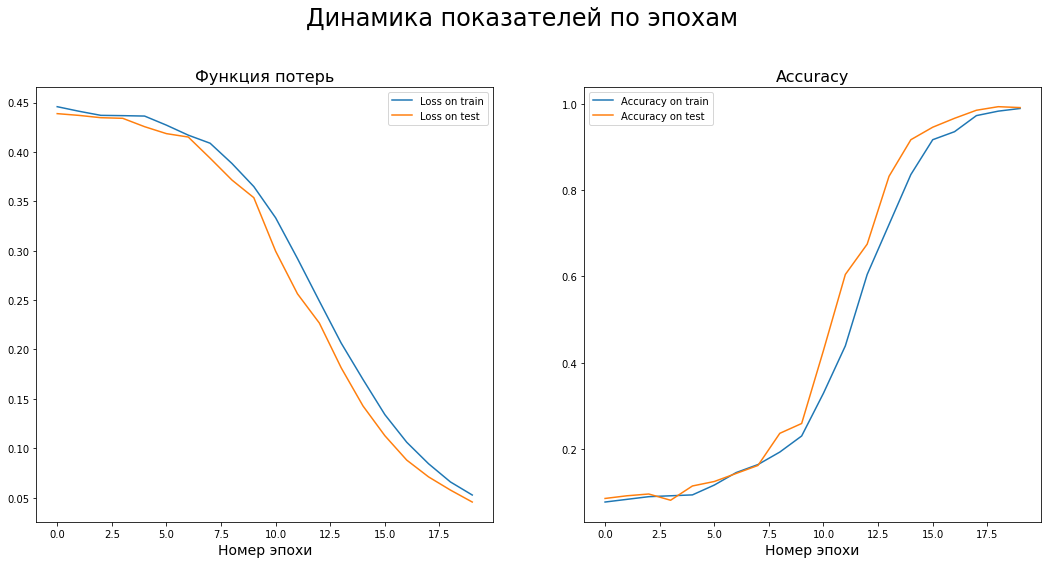

In [ ]:
%%time
EPOCHS = 20
model = BertClassifier()
learning_rate = 2e-5

trained_model = train(model, Dataset(train_data), Dataset(test_data), learning_rate, EPOCHS, 8)